# Problem Description

- COVID-19 brought the airline industry to a screeching halt. The average profit for airlines company was down by almost 50% (Bouwer et al., 2022) when most countries closed down their borders to international travellers. In an industry that operates on razor-thin margins, a huge cutdown on profits like this is potentially lethal for an airline.
- After 1.5 to 2 years of lockdowns, the tourism industry started seeing some upswings in the number of travellers across interational airports. Since most airport & airlines furloughed a vast majority of their staff during peak COVID times as a cost-cutting measure, it was hard to bring everyone back & ready to work before the peak of travelling boom.
- Over the last few months, almost every airline has either delayed a flight by a few hours or outright cancelled a flight due to lack of available personnel (Bergeron-Oliver & Lee, 2022).
- Frustrated customers have taken to social media to vent their frustrations.
- **Hypothetical Scenario**: The marketing teams across all major US airlines are actively looking for solutions to monitor their PR health status, especially on Twitter. 
- **Problem**: Create a deep learning model that can identify the sentiments of the user (positive or negative) from a tweet.
- The data for this problem has been sourced from Kaggle published by Figure Eight (Figure Eight, 2019). 
- Link to this project's Github repository: https://github.com/karansangha/5511_week6_finalproject

**Data Description**
- The dataset has a little over 14.6k tweets
- The dataset has following features
    1. **tweet_id**: unique id for each tweet
    2. **airline_sentiment**:  a pre-determined label for the tweet (neutral, positive or negative)
    3. **airline_sentiment_confidence**: the confidence level for the assigned sentiment value
    4. **negativereason**: the identifed negative reason for the tweet (bad customer service, etc)
    5. **negativereason_confidence**: the confidence level for the assigned negative reason
    6. **airline**:  the airline company that was tagged in the tweet
    7. **airline_sentiment_gold**: unsure what this means but it's `null` for 100% of the rows so it can be safely excluded 
    8. **name**:  username of the tweeter
    9. **negativereason_gold**: unsure what this means but it's `null` for 100% of the rows so it can be safely excluded
    10. **retweet_count**:  number of retweets the tweet received
    11. **text**:  text contents of the tweet
    12. **tweet_coord**:  latitude & longitde values from where the tweet was generated
    13. **tweet_created**:  the exact date & time the tweet was generated
    14. **tweet_location**:  location from which the tweet was generated
    15. **user_timezone**:  timezone from which the tweet was generated


**References**
- Bergeron-Oliver, A., &amp; Lee, M. (2022, June 29). More than half of flights at some Canadian airports getting cancelled, delayed: Data. CTVNews. Retrieved October 9, 2022, from https://www.ctvnews.ca/politics/more-than-half-of-flights-at-some-canadian-airports-getting-cancelled-delayed-data-1.5967481 
- Bouwer, J., Krishnan, V., Saxon, S., &amp; Tufft, C. (2022, April 1). Taking stock of the pandemic's impact on Global Aviation. McKinsey &amp; Company. Retrieved October 9, 2022, from https://www.mckinsey.com/industries/travel-logistics-and-infrastructure/our-insights/taking-stock-of-the-pandemics-impact-on-global-aviation 

# Exploratory Data Analysis

In [430]:
import numpy as np 
import pandas as pd 
import os
import random

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv("tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### Distribution of airline sentiments

<AxesSubplot: xlabel='airline_sentiment', ylabel='count'>

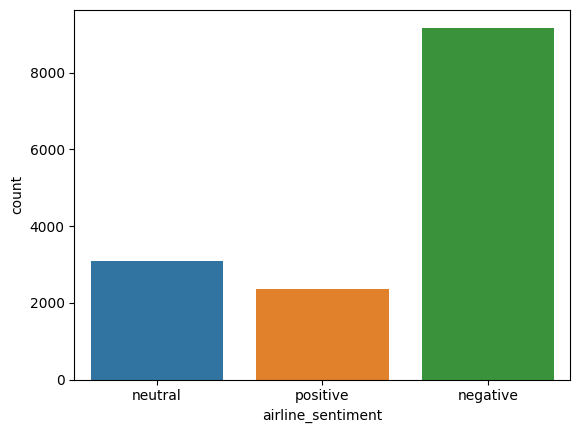

In [5]:
sns.countplot(x="airline_sentiment", data=df)

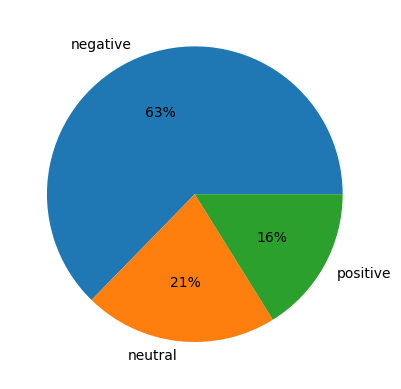

In [45]:
plt.pie(df["airline_sentiment"].value_counts()
        , labels=df["airline_sentiment"].value_counts().index
        , autopct='%.0f%%')
plt.show()

- 63% of the tweets in this dataset are marked `negative`

### Distribution of airline companies

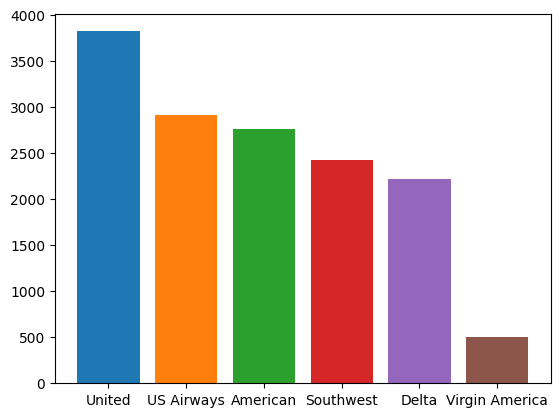

In [85]:
plt.bar(df["airline"].value_counts().index, 
        df["airline"].value_counts(), 
        color=mcolors.TABLEAU_COLORS)
plt.show()

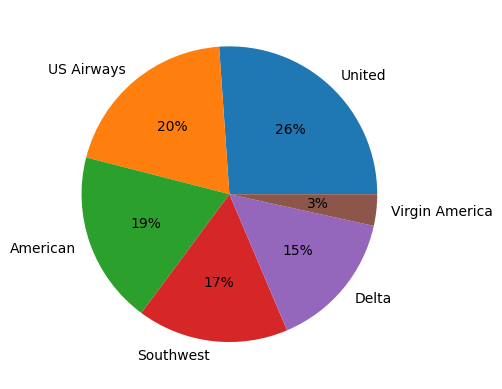

In [47]:
plt.pie(df["airline"].value_counts()
        , labels=df["airline"].value_counts().index
        , autopct='%.0f%%')
plt.show()

### Distribution of sentiments grouped by airline

In [63]:
df.groupby('airline')['airline_sentiment'].value_counts().unstack()

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


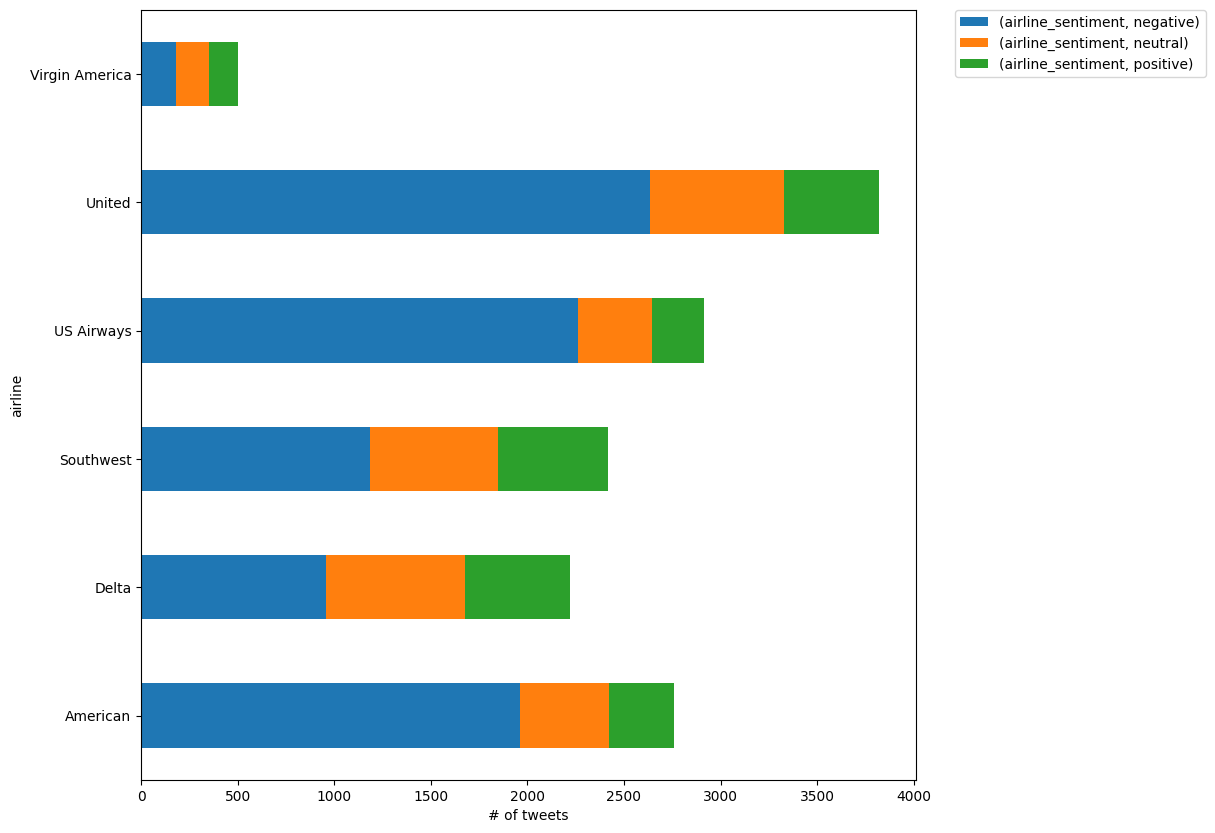

In [86]:
pd.DataFrame(df.groupby('airline')['airline_sentiment'].value_counts()).unstack().plot.barh(figsize=(10,10),stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.xlabel("# of tweets")
plt.show()

- Virgin America receives equal proportion of sentiments in their tweets
- United received a lot more tweets but they also received an overwhelming proportion of negative tweets

### Most common words across each sentiment

In [67]:
from wordcloud import WordCloud, STOPWORDS

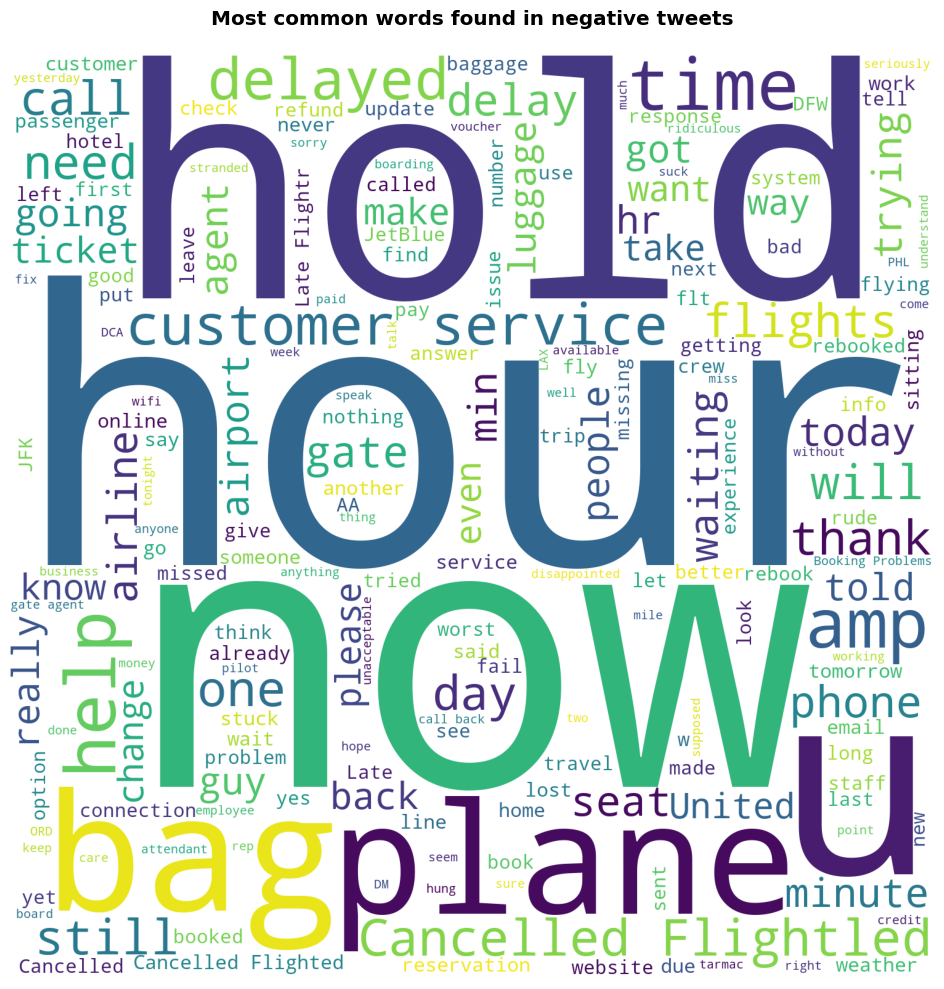

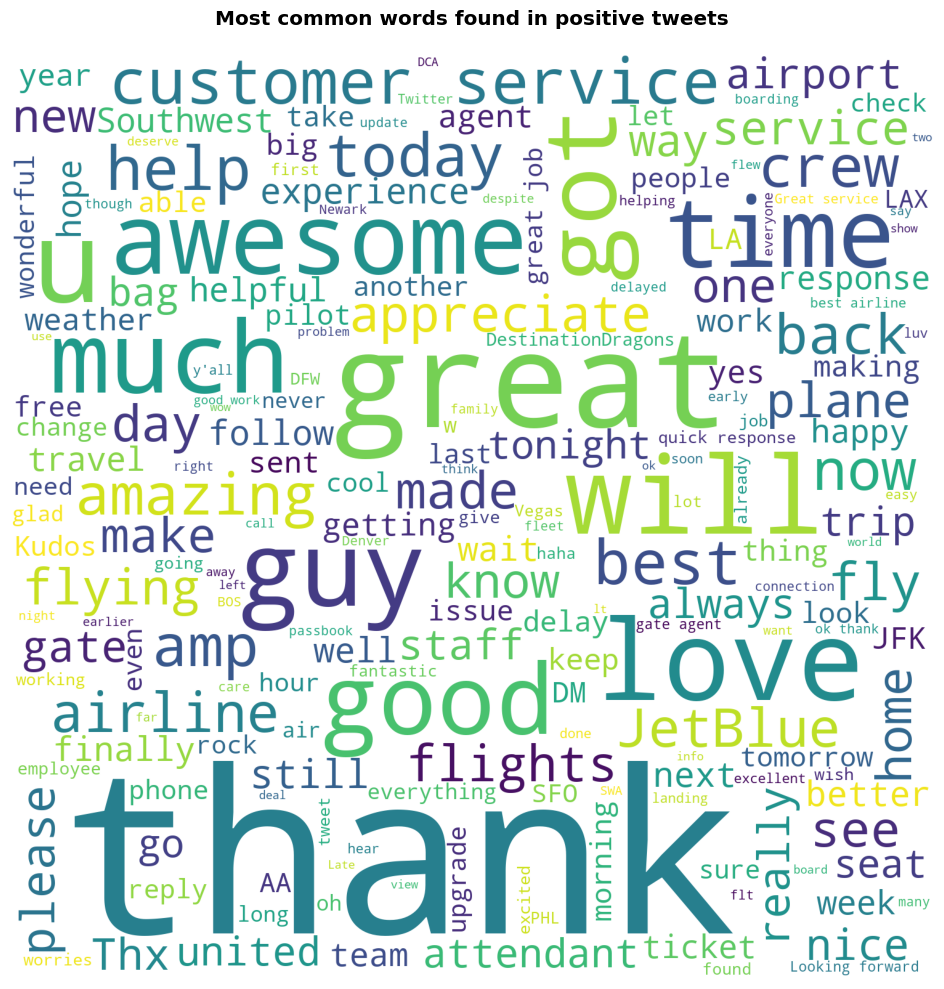

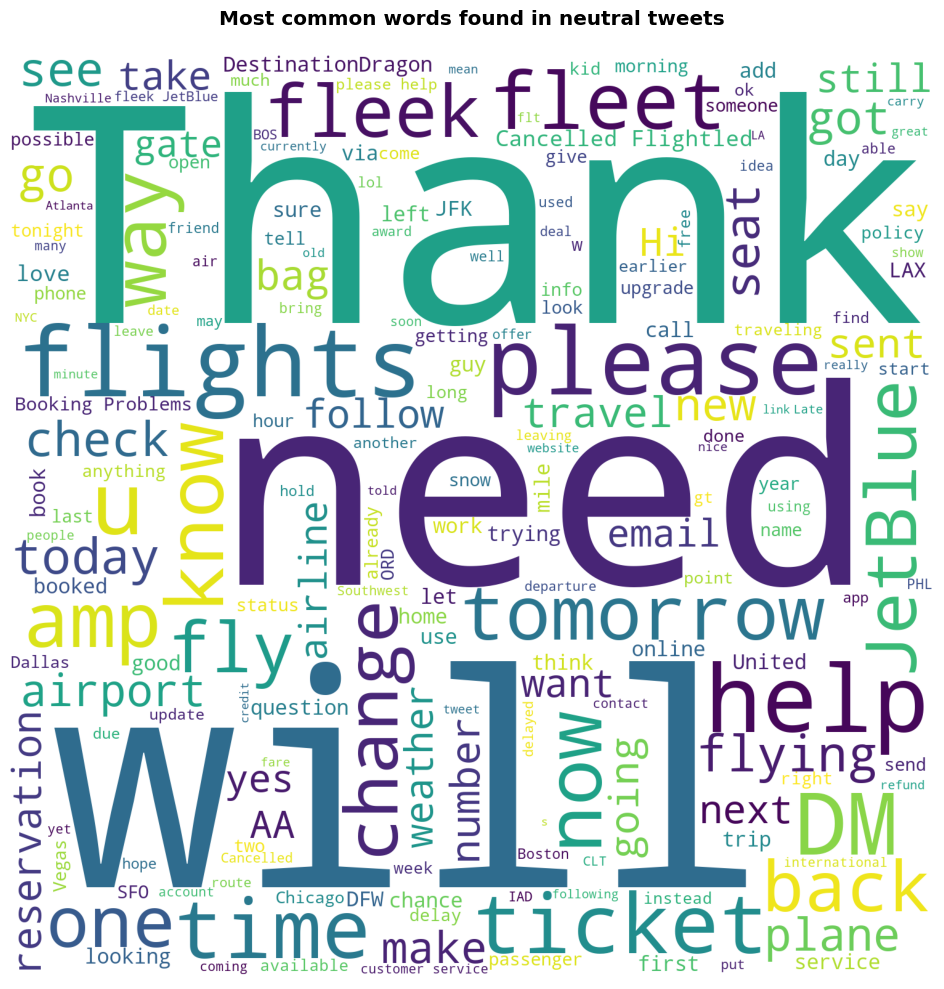

In [429]:
for sentiment in ['negative', 'positive', 'neutral']:
    new_df=df[df['airline_sentiment']==sentiment]
    words = ' '.join(new_df['text'])
    cleaned_word = " ".join([word for word in words.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and word != 'RT'
                                ])
    wordcloud = WordCloud(stopwords=list(STOPWORDS) + ['flight'],
                          background_color='white',
                          width=1500,
                          height=1500
                         ).generate(cleaned_word)
    plt.figure(1,figsize=(14, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Most common words found in {sentiment} tweets\n', 
              fontsize="x-large",
              fontweight="bold"
             )
    plt.show()
    print('\n\n')

- As expected, negative tweets frequently mention words like 'customer service', 'time', 'bag'
- Whereas, positive tweets often mention words such as 'thank', 'appreciate', 'great'

### Distribution of number of words across each sentiment

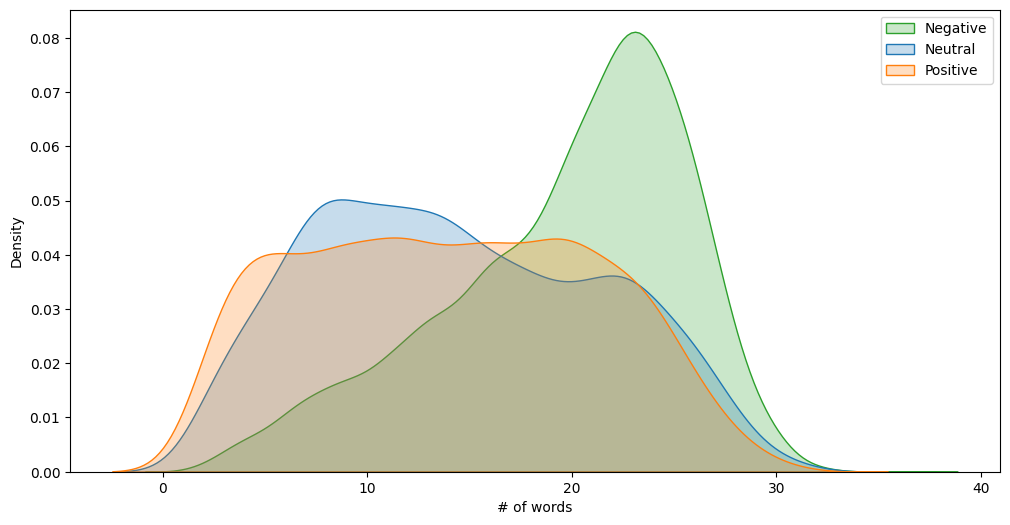

In [203]:
num_neg = df[df['airline_sentiment']=='negative']['text'].apply(lambda x: len(x.split()))
num_neu = df[df['airline_sentiment']=='neutral']['text'].apply(lambda x: len(x.split()))
num_pos = df[df['airline_sentiment']=='positive']['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
sns.kdeplot(num_neg, fill=True, color = 'tab:green').set(xlabel="# of words")
sns.kdeplot(num_neu, fill=True, color = 'tab:blue')
sns.kdeplot(num_pos, fill=True, color = 'tab:orange')

plt.legend(labels=['Negative', 'Neutral','Positive'])
plt.show()

- Interesting takeaway from this viz: Tweets with negative sentiments tend to use more words than neutral & positive. In fact, the other 2 sentiments have almost the same distribution! Very interesting indeed.

## Data Preprocessing

- The current problem requires us to design a solution where a tweet can be associated with a sentiment. 
- To solve the problem, I will only be using the following to create the ML model from the 15 fields available in the dataset
    - airline_sentiment
    - text
- `airline_sentiment` provides the sentiment of the tweet and will be used as our target variable.
- `text` will be cleaned, stemmed & tokenized to be used by the ML model to _learn_ the linkages between different words and associated sentiment.

**Cleanup process** 
- Drop unnecessary columns from the dataset
- Remove stopwords (from nltk library) 
- Remove punctuations 
- Remove any emojis using regex 
- Apply a stemming algorithm (Porter from nltk library) 
- Create one-hot embedding

**What is stemming?** 
- Stemming is the process of reducing variants to a root word 
- For example: chocolates, chocolatey, choco can all be reduced to the same root word - chocolate

**What is one-hot embedding?** 
- Encode each word in a corpus as a integer vector for an embedding layer of a ML model 
- The integers correspond to a word in a giant vocabulary dictionary
- So [“Hello, world”] can be represented as [132, 461] after one-hot embedding

In [89]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

- As noted above (and also in the first visualization), there are 3099 tweets with `neutral` sentiment tagged to them.
- Since a `neutral` tweet doesn't really impact the PR metrics of an airline company, I'll be dropping these tweets from my analysis

In [268]:
new_df = df[df['airline_sentiment']!='neutral']

In [269]:
new_df = new_df[['airline_sentiment', 'text']].reset_index(drop=True)

In [270]:
new_df.head()

,airline_sentiment,text
0,positive,@VirginAmerica plus you've added commercials t...
1,negative,@VirginAmerica it's really aggressive to blast...
2,negative,@VirginAmerica and it's a really big bad thing...
3,negative,@VirginAmerica seriously would pay $30 a fligh...
4,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [271]:
nltk_stopwords = stopwords.words('english')

def remove_stopwords_punc(row):
    # convert the whole tweet to lowercase
    text = row.lower()
    
    # remove @username and http links
    text = re.sub('@[A-Za-z0-9_]+','', text)
    text = re.sub('http[^\s]+','',text)
    
    # keep only alphabets. remove punctuations, numbers
    text = re.sub('[^a-z]', ' ', text)
    
    # remove emojis
    emoji_pattern = re.compile(pattern = "["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'',text)
    
    # split out the tweet into a list
    # ex: "hello world !" -> ["hello", "world", "!"]
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in nltk_stopwords]
    
    return ' '.join(text)

In [272]:
test_str = "@test hello world ! \U0001f602" #\U0001f602 is the laughing emoji
print(f'original text: {test_str}')
print(f'cleaned up text: {remove_stopwords_punc(test_str)}')
print(f'expected text: hello world')

original text: @test hello world ! 😂
cleaned up text: hello world
expected text: hello world


In [273]:
new_df["clean_text"] = new_df["text"].apply(remove_stopwords_punc)

In [274]:
port_stem = PorterStemmer()

def port_stemmer(row):
    text = row.split()
    text = [port_stem.stem(word) for word in text]
    return ' '.join(text)

new_df["clean_stemmed_text"] = new_df["clean_text"].apply(port_stemmer)

In [275]:
new_df.head()

,airline_sentiment,text,clean_text,clean_stemmed_text
0,positive,@VirginAmerica plus you've added commercials t...,plus added commercials experience tacky,plu ad commerci experi tacki
1,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,realli aggress blast obnoxi entertain guest fa...
2,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing,realli big bad thing
3,negative,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay flight seats playing reall...,serious would pay flight seat play realli bad ...
4,positive,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly every time fly vx ear worm go away,ye nearli everi time fli vx ear worm go away


**Convert the cleaned text data into one hot vectors**

In [276]:
VOCABULARY_SIZE = 5000
one_hot_list = [one_hot(row, VOCABULARY_SIZE) for row in new_df["clean_stemmed_text"].values]

In [277]:
max_len_str = new_df.clean_stemmed_text.str.len().max()
max_len_str

116

In [278]:
embedded_docs = pad_sequences(one_hot_list, padding='pre', maxlen=max_len_str)

**Convert airline_sentiment column into categoical**

In [279]:
new_df['target'] = new_df['airline_sentiment'].map(
    {
        'negative': 1,
        'positive': 0
    }
)

In [280]:
new_df.head()

,airline_sentiment,text,clean_text,clean_stemmed_text,target
0,positive,@VirginAmerica plus you've added commercials t...,plus added commercials experience tacky,plu ad commerci experi tacki,0
1,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,realli aggress blast obnoxi entertain guest fa...,1
2,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing,realli big bad thing,1
3,negative,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay flight seats playing reall...,serious would pay flight seat play realli bad ...,1
4,positive,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly every time fly vx ear worm go away,ye nearli everi time fli vx ear worm go away,0


# Model Architecture

In [257]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [252]:
X = np.array(embedded_docs)
y = np.array(new_df["target"])
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [254]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((9232, 116), (9232,), (2309, 116), (2309,))

### Helper functions

In [385]:
import itertools

def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[1]), range(cm.shape[0])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    
def evaluate_model(history, model, X_validation, y_validation):
    # Plot accuracy and loss plots
    if history is not None:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model One Accuracy per Epoch')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validate'], loc='upper left')
        plt.show();

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model One Loss per Epoch')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validate'], loc='upper left')
        plt.show();

    # Show confusion matirx
    y_valid_pred = model.predict(X_validation)
    y_valid_pred = [0 if pred < 0.5 else 1 for pred in y_valid_pred]
    cm_train = np.flip(confusion_matrix(y_validation, y_valid_pred))
    plot_confusion_matrix(cm_train,["Positive", "Negative"])
    plt.show();
    
    # Calculate the fun metrics
    print(f'Total negative sentiment tweets detected in validation set: {cm_train[1][1]} of {cm_train[1][1]+cm_train[1][0]}')
    print(f'Total positive sentiment tweets detected in validation set: {cm_train[0][0]} of {cm_train[0][1]+cm_train[0][0]}')
    print(f'Probability to detect a negative sentiment tweet in the validation set: {cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]):0.2f}')
    print(f'Probability to detect a positive sentiment tweet in the validation set: {(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])):0.2f}')
    print(f"Accuracy of unsupervised model on the validation set: {100*(accuracy_score(y_validation, y_valid_pred)):0.2f}%")

**Train the ML Model** 

What is an embedding layer?
- Embedding layer converts the input integer indices into corresponding word vectors. Word embedding is a way of representing a word as a vector. After training, words with similar meanings often have similar vectors

What is a LSTM layer?
- Long Short-Term Memory Layer based on a paper by Hochreiter published in 1997. LSTM layers learn long-term dependencies between time steps in sequence data

What is a dropout layer? 
- Dropout layer randomly sets inputs to 0 during training to prevent overfitting.

What is a dense layer? 
- Dense layer is a simple layer of neurons which receives input from all the neurons of the previous layer. In our model, we’ll be using Dense layer as our output layer with a sigmoid activation since we’re solving a binary classification problem.

### Setup a baseline model

In [313]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE+1, 40, input_length=max_len_str))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [314]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 116, 40)           200040    
                                                                 
 lstm_11 (LSTM)              (None, 64)                26880     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 226,985
Trainable params: 226,985
Non-trainable params: 0
_________________________________________________________________


In [315]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_data=(X_validation, y_validation))

Epoch 1/10


2022-10-09 19:13:54.436964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 19:13:54.563817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 19:13:54.891102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


289/289 [==============================] - ETA: 0s - loss: 0.3453 - accuracy: 0.8572

2022-10-09 19:14:06.229510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 19:14:06.286430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


289/289 [==============================] - 14s 43ms/step - loss: 0.3453 - accuracy: 0.8572 - val_loss: 0.2357 - val_accuracy: 0.9017
Epoch 2/10
289/289 [==============================] - 11s 38ms/step - loss: 0.1781 - accuracy: 0.9305 - val_loss: 0.2449 - val_accuracy: 0.9034
Epoch 3/10
289/289 [==============================] - 11s 37ms/step - loss: 0.1342 - accuracy: 0.9475 - val_loss: 0.2638 - val_accuracy: 0.9021
Epoch 4/10
289/289 [==============================] - 11s 37ms/step - loss: 0.1093 - accuracy: 0.9597 - val_loss: 0.2890 - val_accuracy: 0.9004
Epoch 5/10
289/289 [==============================] - 11s 37ms/step - loss: 0.0884 - accuracy: 0.9677 - val_loss: 0.3596 - val_accuracy: 0.9034
Epoch 6/10
289/289 [==============================] - 11s 37ms/step - loss: 0.0751 - accuracy: 0.9722 - val_loss: 0.3648 - val_accuracy: 0.8987
Epoch 7/10
289/289 [==============================] - 11s 40ms/step - loss: 0.0625 - accuracy: 0.9783 - val_loss: 0.3915 - val_accuracy: 0.9000
Epo

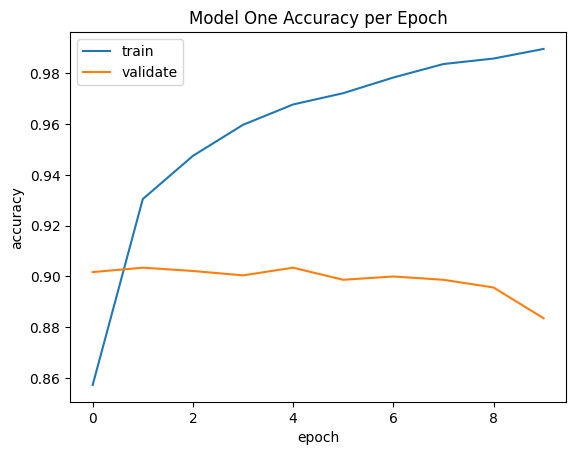

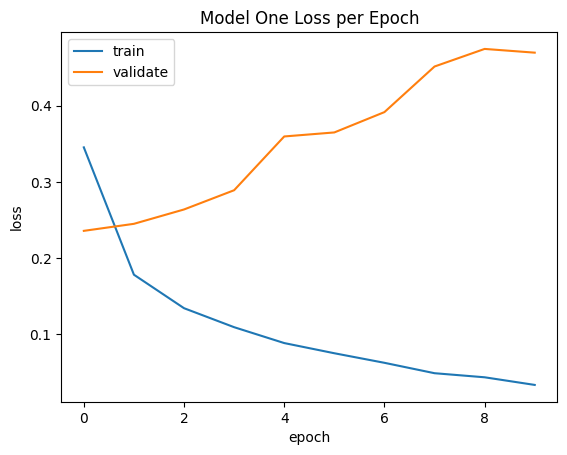

73/73 [==============================] - 1s 13ms/step


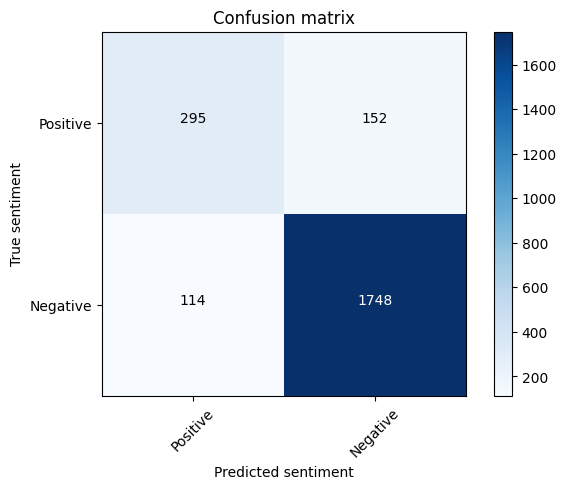

Total negative sentiment tweets detected in validation set: 1748 of 1862
Total positive sentiment tweets detected in validation set: 295 of 447
Probability to detect a negative sentiment tweet in the validation set: 0.94
Probability to detect a positive sentiment tweet in the validation set: 0.66
Accuracy of unsupervised model on the validation set: 88.48%


In [386]:
evaluate_model(history, model, X_validation, y_validation)

- Since lost per epoch for the `validate` dataset increases with # of epochs, the model is probably overfitting to the training data and thus generalizing very poorly.

### Train a bigger & better model

In [345]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                              verbose=1, mode='max', min_lr=1e-6)

callbacks_list = [early_stop, reduce_lr]

- In this model, I'm also added 2 callback functions
    - `EarlyStopping`: Stop the model training if `val_acc` doesn't improve for 3 back-to-back epochs
    - `ReduceLROnPlateau`: If `val_acc` doesn't improve for 2 straight epochs, reduce the learning rate of the optimizer.

In [346]:
model2 = Sequential()
model2.add(Embedding(VOCABULARY_SIZE+1, 40, input_length=max_len_str))
model2.add(LSTM(256, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(64))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(1e-4)
model2.compile(loss='binary_crossentropy'
               , optimizer=opt
               , metrics=['accuracy']
              )

In [347]:
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 116, 40)           200040    
                                                                 
 lstm_27 (LSTM)              (None, 116, 256)          304128    
                                                                 
 dropout_18 (Dropout)        (None, 116, 256)          0         
                                                                 
 lstm_28 (LSTM)              (None, 116, 128)          197120    
                                                                 
 dropout_19 (Dropout)        (None, 116, 128)          0         
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_20 (Dropout)        (None, 64)              

In [348]:
history2 = model2.fit(X_train, y_train, 
                    epochs=10, 
                    validation_data=(X_validation, y_validation),
                    callbacks=callbacks_list)

Epoch 1/10


2022-10-09 20:13:49.532939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 20:13:49.781233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 20:13:49.968299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 20:13:50.150450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 20:13:50.420597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 20:13:50.740598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 20:13:51.034846: I tensorflow/core/grappler/optimizers/cust

289/289 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.7911

2022-10-09 20:14:15.649845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 20:14:15.749474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 20:14:15.903834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 20:14:16.081660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


289/289 [==============================] - 31s 98ms/step - loss: 0.5307 - accuracy: 0.7911 - val_loss: 0.4875 - val_accuracy: 0.8064 - lr: 1.0000e-04
Epoch 2/10
289/289 [==============================] - 26s 89ms/step - loss: 0.4752 - accuracy: 0.7939 - val_loss: 0.4063 - val_accuracy: 0.8393 - lr: 1.0000e-04
Epoch 3/10
289/289 [==============================] - 26s 90ms/step - loss: 0.3654 - accuracy: 0.8362 - val_loss: 0.3014 - val_accuracy: 0.8904 - lr: 1.0000e-04
Epoch 4/10
289/289 [==============================] - 26s 88ms/step - loss: 0.2512 - accuracy: 0.8973 - val_loss: 0.2763 - val_accuracy: 0.8952 - lr: 1.0000e-04
Epoch 5/10
289/289 [==============================] - 24s 83ms/step - loss: 0.2099 - accuracy: 0.9203 - val_loss: 0.2663 - val_accuracy: 0.8952 - lr: 1.0000e-04
Epoch 6/10
289/289 [==============================] - 24s 84ms/step - loss: 0.1824 - accuracy: 0.9328 - val_loss: 0.2650 - val_accuracy: 0.8982 - lr: 1.0000e-04
Epoch 7/10
289/289 [=========================

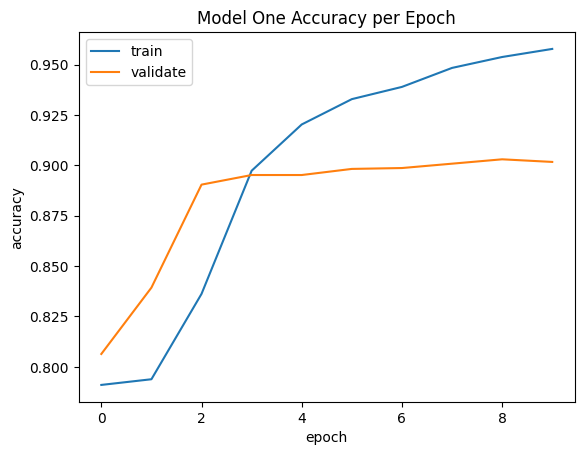

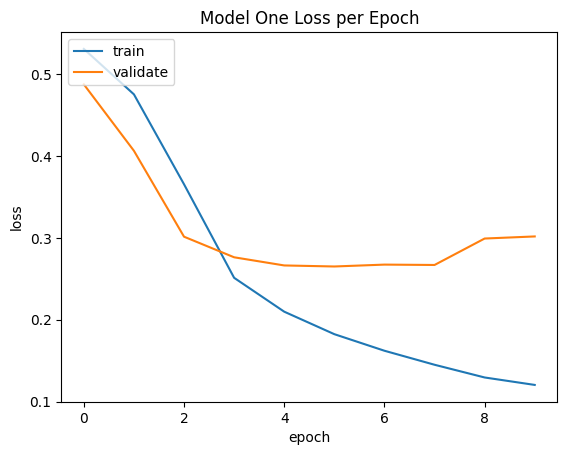

73/73 [==============================] - 3s 35ms/step


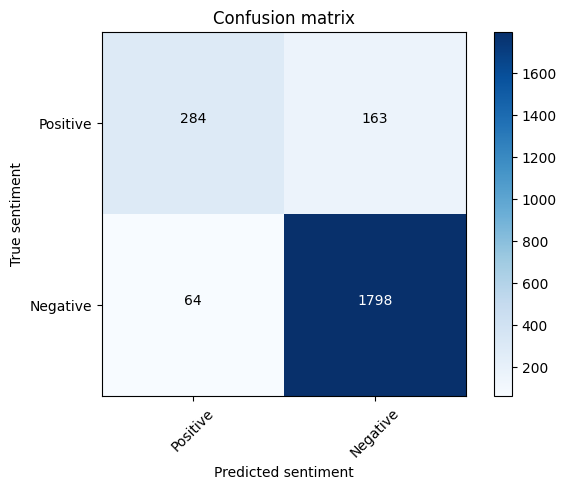

Total negative sentiment tweets detected in validation set: 1798 of 1862
Total positive sentiment tweets detected in validation set: 284 of 447
Probability to detect a negative sentiment tweet in the validation set: 0.97
Probability to detect a positive sentiment tweet in the validation set: 0.64
Accuracy of unsupervised model on the validation set: 90.17%


In [387]:
evaluate_model(history2, model2, X_validation, y_validation)

- The accuracy of the model improved from 88% to 90%
- The probablity to detect a negative tweet has also gone up from 93% to 97%

### Try a different model architecture

- Even though the neural network's performed phenomenally well with ~ 97% chance of catching a negative rate. I would like to try a non-neural network architecture to see if we can do something better with a simpler archiecture.
- A simple architecture would be much faster to train & inference.
- This would only be worth it if the evaluation metrics are better

In [364]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.ensemble import RandomForestClassifier

In [365]:
clf = RandomForestClassifier()

In [370]:
clf.fit(X_train, y_train)

RandomForestClassifier()

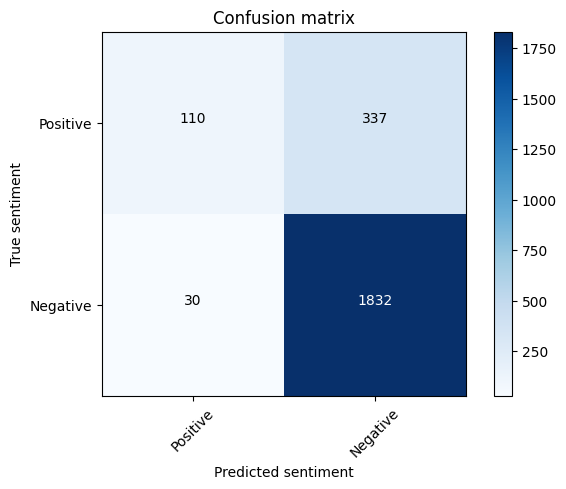

Total negative sentiment tweets detected in validation set: 1832 of 1862
Total positive sentiment tweets detected in validation set: 110 of 447
Probability to detect a negative sentiment tweet in the validation set: 0.98
Probability to detect a positive sentiment tweet in the validation set: 0.25
Accuracy of unsupervised model on the validation set: 84.11%


In [388]:
evaluate_model(None, clf, X_validation, y_validation)

- Super fast to train. It took less than 30 seconds to train. Meanwhile the LSTM model takes around 4 to 5 mins.
- Even though the probability to detect a negative sentiment is 98% which is higher than LSTM's 97% **but** the probability of detecting a positive sentiment tweet is way worse at 25%.
- Despite the pros of the `RandomForestClassifier`, I've chosen to go ahead with the hyperparameter tuning of the LSTM model.

## Hyperparameter Tuning

In [352]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [405]:
def build_model(num_lstm_layers=1, num_lstm_cells = 200, 
                dropout_level=0.5, learning_rate=1e-4):
    nn = Sequential()
    nn.add(Embedding(VOCABULARY_SIZE+1, 40, input_length=max_len_str))
    nn.add(Dropout(dropout_level))
    for i in range(num_lstm_layers):
        nn.add(LSTM(num_lstm_cells, return_sequences=True))
        nn.add(Dropout(dropout_level))
    nn.add(LSTM(num_lstm_cells))
    nn.add(Dropout(dropout_level))
    nn.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate)
    nn.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return nn

In [425]:
grid_model = KerasClassifier(build_fn=build_model, verbose=0)
parameters = {
    'epochs': [10, 15],
    'num_lstm_layers': [1, 2, 3],
    'learning_rate': [1e-4, 1e-5]
}
grid_search = GridSearchCV(estimator = grid_model, 
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 2, verbose=1)

In [426]:
grid_search_hist = grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


2022-10-09 22:21:29.909694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:21:30.153027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:21:30.386675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:21:30.804581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:21:31.243480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:22:50.324382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:22:50.389724: I tensorflow/core/grappler/optimizers/cust

  1/145 [..............................] - ETA: 1:32

2022-10-09 22:22:50.595747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


145/145 [==============================] - 4s 26ms/step


2022-10-09 22:22:55.438321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:22:55.660818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:22:55.913856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:22:56.435407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:22:56.899222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:24:16.113317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:24:16.176951: I tensorflow/core/grappler/optimizers/cust

  1/145 [..............................] - ETA: 1:30

2022-10-09 22:24:16.368617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


145/145 [==============================] - 4s 26ms/step


2022-10-09 22:24:21.567134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:24:21.899971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:24:22.165457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:24:22.395126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:24:22.771122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:24:23.159625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:24:23.555752: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 6s 38ms/step


2022-10-09 22:26:21.750343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:26:22.046996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:26:22.282331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:26:22.555336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:26:23.071668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:26:23.531114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:26:23.985942: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 9s 40ms/step


2022-10-09 22:28:25.708540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:28:26.084043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:28:26.355147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:28:26.625284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:28:26.878234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:28:27.357373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:28:27.819180: I tensorflow/core/grappler/optimizers/cust

  1/145 [..............................] - ETA: 2:43

2022-10-09 22:30:55.693956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


145/145 [==============================] - 8s 49ms/step


2022-10-09 22:31:04.615069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:31:04.992474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:31:05.214746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:31:05.433200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:31:05.666832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:31:06.098591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:31:06.584726: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 8s 49ms/step


2022-10-09 22:33:42.686303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:33:42.946736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:33:43.195142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:33:43.653070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:33:44.125624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:35:07.874276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:35:07.947340: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 5s 28ms/step


2022-10-09 22:35:13.369452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:35:13.641578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:35:13.907965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:35:14.461114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:35:14.946921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:36:37.185341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:36:37.261169: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 5s 27ms/step


2022-10-09 22:36:42.942894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:36:43.264476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:36:43.532636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:36:43.801594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:36:44.324124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:36:44.799991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:36:45.267450: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 7s 40ms/step


2022-10-09 22:38:48.747470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:38:49.071056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:38:49.346491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:38:49.629257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:38:50.152712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:38:50.643123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:38:51.117074: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 9s 41ms/step


2022-10-09 22:40:57.797258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:40:58.183624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:40:58.452118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:40:58.726498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:40:58.988721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:40:59.551564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:41:00.049659: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 9s 52ms/step


2022-10-09 22:43:42.848828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:43:43.258516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:43:43.554338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:43:43.865272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:43:44.141393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:43:44.705512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:43:45.228267: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 9s 52ms/step


2022-10-09 22:46:27.007639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:46:27.267639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:46:27.553642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:46:28.119809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:46:28.657283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:48:33.466124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:48:33.537276: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 5s 27ms/step


2022-10-09 22:48:38.924990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:48:39.184656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:48:39.465610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:48:40.034185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:48:40.533250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:50:45.225891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:50:45.299665: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 5s 27ms/step


2022-10-09 22:50:51.055713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:50:51.390588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:50:51.692292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:50:51.987631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:50:52.528954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:50:53.054815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:50:53.531643: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 7s 40ms/step


2022-10-09 22:53:56.921058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:53:57.272542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:53:57.569535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:53:57.901073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:53:58.460715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:53:58.980093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:53:59.482100: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 7s 42ms/step


2022-10-09 22:57:05.268631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:57:05.679186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:57:05.983960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:57:06.280970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:57:06.571586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:57:07.111964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 22:57:07.628546: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 9s 54ms/step


2022-10-09 23:01:04.519692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:01:04.915000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:01:05.202962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:01:05.516237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:01:05.810810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:01:06.386735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:01:06.893997: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 9s 55ms/step


2022-10-09 23:05:05.099461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:05:05.399348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:05:05.854375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:05:06.698271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:05:07.570299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:07:10.834708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:07:10.911998: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 5s 27ms/step


2022-10-09 23:07:16.284071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:07:16.588333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:07:16.894724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:07:17.500867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:07:18.038343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:09:21.569221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:09:21.649661: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 5s 28ms/step


2022-10-09 23:09:27.501095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:09:27.844908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:09:28.212021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:09:28.634010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:09:29.460355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:09:30.188980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:09:30.697909: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 7s 40ms/step


2022-10-09 23:12:34.531545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:12:34.971742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:12:35.296549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:12:35.659289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:12:36.334383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:12:36.866945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:12:37.380573: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 7s 43ms/step


2022-10-09 23:15:44.391234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:15:44.839186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:15:45.225235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:15:45.642933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:15:46.026094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:15:46.726660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:15:47.288552: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 9s 53ms/step


2022-10-09 23:19:45.319341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:19:45.759908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:19:46.184542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:19:46.595720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:19:46.903707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:19:47.830844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:19:48.569702: I tensorflow/core/grappler/optimizers/cust

145/145 [==============================] - 10s 54ms/step


2022-10-09 23:23:46.527046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:23:46.881608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:23:47.288480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:23:48.160690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:23:48.901824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# Results

2022-10-09 23:30:27.202809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:30:27.333904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-09 23:30:27.766103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - 3s 32ms/step


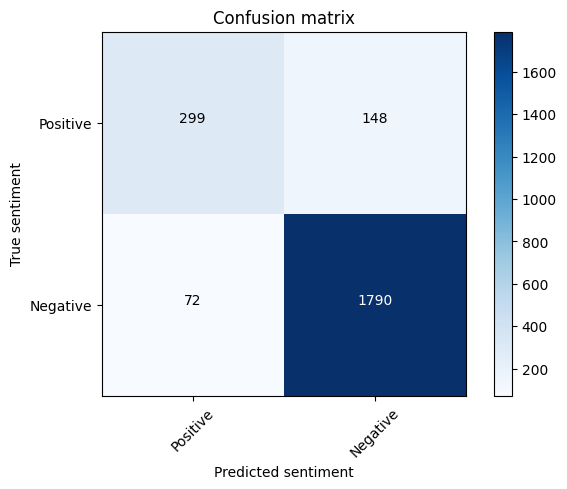

Total negative sentiment tweets detected in validation set: 1790 of 1862
Total positive sentiment tweets detected in validation set: 299 of 447
Probability to detect a negative sentiment tweet in the validation set: 0.96
Probability to detect a positive sentiment tweet in the validation set: 0.67
Accuracy of unsupervised model on the validation set: 90.47%


In [428]:
evaluate_model(None, grid_search_hist.best_estimator_, X_validation, y_validation)

- Hyperparameter tuning improved scores in certain areas while maintained the status quo in others when compared to the second LSTM model.
- Overall accuracy of the model improved from 84% to 90%. That's an improvement of 7%
- However, the probability of detecting a tweet with negative sentiment went _down_ from 97% to 96%. Not a big drop but a drop nonetheless.
- There could be a lot of factors why a hyperparameter tuned model isn't performing miles ahead of a _manually_ tuned model
    - The parameter grid is too small
    - Need more data 

# Conclusion

- I explored 2 different techniques of identifying the sentiment of the user towards an airline from a tweet.
    - Deep learning based LSTM model
    - Random Forest Classifier
- Even though the non-neural network method of using RandomForestClassifier trained _really_ fast, it lost a lot in terms of detecting positive sentiment and overall accuracy of the model. 
- Based on the result above, I chose to hypertune the LSTM model to maximize the performance I can extract from it. Despite the hypertuning process taking over an hour
    - I didn't see a remarkable improvement in the detection rate of negative sentiment tweets. 
    - But the performance boost in detecting positive tweets was remarkable.
- The final model had the following stats
    - 96% chance of detecting a negative tweet while the probability of detecting a positive tweet hovered around 67%. 
    - Overall accuracy of the model clocked in at 90%.
    - Given the context of this challenge, I believe it's more important for the model to better at detecting negative tweets than positive since the negative ones usually require a promopt & thorough response/investigation.
- For next steps in this journey, I would like to
    - Gather more data to feed into the model. This will massively improve the generalization of the model.
    - Try various other techniques of text classification: BayesClassifier, SVMs, etc.
    - Publish this model as a REST API for people to use where they send a tweet in and get the sentiment as an output.